In [82]:
import os
import csv
import math

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [83]:
# settings

fs = 17  # fontsize
sfs = 13.5  # small fontsize

FIGURE_PATH = './figures'

METHOD_STR_TO_NAME = {
    'bfs': '$H_0$',
    'ah': '$H$',
    'ah+': '$H^+$',
}

# plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.size'] = 10
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# timeout = 300 * 1000       # in ms
timeout = 1800       # in s

In [84]:
# load data

# header
# timestamp	case	step name	method
# src plan node #	dst plan node #	path length	status
# time cost (ms)	explored plan #	generated plan #

filename = './result.csv'
data = []
with open(filename) as csvfile:
    csvreader = csv.reader(csvfile)
    header = next(csvreader)
    for row in csvreader:
        del row[1]      # rm data_id
        data.append([
            row[0],  # timestamp
            row[1],  # case
            row[2],  # step name
            row[3],  # method
            int(row[4]),  # src plan node
            int(row[5]),  # dst plan node
            int(row[6]),  # path length
            row[7],  # status
            float(row[8]) / 1000,  # time cost in ms -> s
            int(row[9]),  # explored plan #
            int(row[10]),  # generated plan #
        ])

data

[['2024-07-26 20:30:43',
  'bug1-0',
  'org.apache.spark.sql.catalyst.optimizer.InferFiltersFromConstraints',
  'ah+',
  5,
  6,
  1,
  'AlgoStatus.SUCCESS',
  0.00185394287109375,
  9,
  2],
 ['2024-07-26 20:30:43',
  'bug1-0',
  'org.apache.spark.sql.catalyst.optimizer.InferFiltersFromConstraints',
  'ah',
  5,
  6,
  1,
  'AlgoStatus.SUCCESS',
  0.001157522201538086,
  9,
  2],
 ['2024-07-26 20:30:43',
  'bug1-0',
  'org.apache.spark.sql.catalyst.optimizer.InferFiltersFromConstraints',
  'bfs',
  5,
  6,
  1,
  'AlgoStatus.SUCCESS',
  0.0009496212005615234,
  9,
  2],
 ['2024-07-26 20:30:43',
  'ssb-q1',
  'org.apache.spark.sql.catalyst.optimizer.Optimizer$FinishAnalysis',
  'ah+',
  11,
  9,
  1,
  'AlgoStatus.SUCCESS',
  0.010416746139526367,
  21,
  6],
 ['2024-07-26 20:30:43',
  'ssb-q1',
  'org.apache.spark.sql.catalyst.optimizer.Optimizer$FinishAnalysis',
  'ah',
  11,
  9,
  1,
  'AlgoStatus.SUCCESS',
  0.009511232376098633,
  21,
  6],
 ['2024-07-26 20:30:43',
  'ssb-q1',
  

In [85]:
# summarize (count and percentage) the case and step name for a given path length

target_path_length = 7

tmp_data = [row for row in data if row[6] == target_path_length]

# step name -> case name -> count
step_case_cnt = {}
for row in tmp_data:
    step_name = row[2]
    case_name = row[1]
    if step_name not in step_case_cnt:
        step_case_cnt[step_name] = {}
    if case_name not in step_case_cnt[step_name]:
        step_case_cnt[step_name][case_name] = 0
    step_case_cnt[step_name][case_name] += 1

step_case_cnt

{'org.apache.spark.sql.catalyst.optimizer.ColumnPruning': {'ssb-q4': 3,
  'bug0-0': 3},
 'org.apache.spark.sql.catalyst.optimizer.Optimizer$FinishAnalysis': {'ssb-q6': 3,
  'ssb-q7': 3,
  'ssb-q12': 3},
 'org.apache.spark.sql.catalyst.optimizer.ObjectSerializerPruning': {'ssb-q9': 3,
  'ssb-q6': 3},
 'org.apache.spark.sql.catalyst.optimizer.CollapseProject': {'ssb-q12': 3}}

In [86]:
# max time
max_time = max([row[8] for row in data])
print(max_time)

# max time of ahp (successed)
max_ahp = max([row[8] for row in data if row[3] == 'ah+' and 'SUCCESS' in row[7]])
print('max time of ahp:', max_ahp)

# case and how many cases are there
cases = set([row[1] for row in data])
print(cases, len(cases))

# how many dfs is timeout
timeout_cnt = sum(['TIMEOUT' in row[7] for row in data if row[3] == 'bfs'])
print(timeout_cnt)
# how many different test cases (case name, step name)
case_cnt = len(set([(row[1], row[2]) for row in data]))
print(case_cnt)

# how many are finished <= 1s, and percentage
case_cnt = len(data) / 3
bfs_cnt = sum([row[8] <= 10 for row in data if row[3] == 'bfs'])
ah_cnt = sum([row[8] <= 10 for row in data if row[3] == 'ah'])
ahp_cnt = sum([row[8] <= 10 for row in data if row[3] == 'ah+'])
print(f'how many are finished <= 10s: {bfs_cnt}, {ah_cnt}, {ahp_cnt}')
print(f'percentage: {bfs_cnt / case_cnt:.1%}, {ah_cnt / case_cnt:.1%}, {ahp_cnt / case_cnt:.1%}')

1840.6080422401428
max time of ahp: 1032.4448313713074
{'ssb-q1', 'ssb-q12', 'ssb-q10', 'ssb-q13', 'bug1-0', 'ssb-q3', 'ssb-q11', 'ssb-q7', 'ssb-q8', 'bug0-0', 'ssb-q6', 'ssb-q4', 'ssb-q5', 'ssb-q9', 'bug4-0', 'ssb-q2', 'bug4-1'} 17
18
59
how many are finished <= 10s: 41, 57, 73
percentage: 50.0%, 69.5%, 89.0%


In [87]:
# group by method and path length, then calculate the average time cost / explored plan cnt / generated plan cnt

# methods = list(set([row[3] for row in data]))
methods = ['bfs', 'ah', 'ah+']
path_lengths = set([row[6] for row in data])
# add 6
path_lengths.add(9)     # added fake group
metric_name_dict = {
    'time_cost': 'Avg. time cost (sec)',
    'explored_plan_cnt': 'Avg. # of explored plans',
    'generated_plan_cnt': 'Avg. # of visited plans',
}

grouped_data = {}
for method in methods:
    grouped_data[method] = {}
    for path_length in path_lengths:
        grouped_data[method][path_length] = {
            'records': [],
            'time_cost_data': [],
            'explored_plan_cnt_data': [],
            'generated_plan_cnt_data': [],
        }

for row in data:
    method = row[3]
    path_length = row[6]
    grouped_data[method][path_length]['records'].append(row)
    grouped_data[method][path_length]['time_cost_data'].append(row[8])
    grouped_data[method][path_length]['explored_plan_cnt_data'].append(row[9])
    grouped_data[method][path_length]['generated_plan_cnt_data'].append(row[10])
    
def get_confidence_interval(records):
    return stats.t.interval(0.95, len(records) - 1, loc=np.mean(records), scale=stats.sem(records))

def filter_timeout(data, records):
    return [d for r, d in zip(records, data) if 'SUCCESS' in r[7]]
    # return [d for r, d in zip(records, data) if r[8] <= timeout]

for method in methods:
    for path_length in path_lengths:
        category = grouped_data[method][path_length]
        
        category['time_cost'] = {
            'mean': np.mean(category['time_cost_data']),
            'mean_no_timeout': np.mean(filter_timeout(category['time_cost_data'], category['records'])),
            'confidence_interval': get_confidence_interval(category['time_cost_data']),
            'std': np.std(category['time_cost_data']),
            'q1': np.percentile(category['time_cost_data'], 25) if len(category['time_cost_data']) > 0 else 0,
            'q3': np.percentile(category['time_cost_data'], 75) if len(category['time_cost_data']) > 0 else 0,
        }
        category['explored_plan_cnt'] = {
            'mean': np.mean(category['explored_plan_cnt_data']),
            'mean_no_timeout': np.mean(filter_timeout(category['explored_plan_cnt_data'], category['records'])),
            'confidence_interval': get_confidence_interval(category['explored_plan_cnt_data']),
            'std': np.std(category['explored_plan_cnt_data']),
            'q1': np.percentile(category['explored_plan_cnt_data'], 25) if len(category['explored_plan_cnt_data']) > 0 else 0,
            'q3': np.percentile(category['explored_plan_cnt_data'], 75) if len(category['explored_plan_cnt_data']) > 0 else 0,
        }
        category['generated_plan_cnt'] = {
            'mean': np.mean(category['generated_plan_cnt_data']),
            'mean_no_timeout': np.mean(filter_timeout(category['generated_plan_cnt_data'], category['records'])),
            'confidence_interval': get_confidence_interval(category['generated_plan_cnt_data']),
            'std': np.std(category['generated_plan_cnt_data']),
            'q1': np.percentile(category['generated_plan_cnt_data'], 25) if len(category['generated_plan_cnt_data']) > 0 else 0,
            'q3': np.percentile(category['generated_plan_cnt_data'], 75) if len(category['generated_plan_cnt_data']) > 0 else 0,
        }


grouped_data

{'bfs': {1: {'records': [['2024-07-26 20:30:43',
     'bug1-0',
     'org.apache.spark.sql.catalyst.optimizer.InferFiltersFromConstraints',
     'bfs',
     5,
     6,
     1,
     'AlgoStatus.SUCCESS',
     0.0009496212005615234,
     9,
     2],
    ['2024-07-26 20:30:43',
     'ssb-q1',
     'org.apache.spark.sql.catalyst.optimizer.Optimizer$FinishAnalysis',
     'bfs',
     11,
     9,
     1,
     'AlgoStatus.SUCCESS',
     0.008506059646606445,
     21,
     6],
    ['2024-07-26 20:30:43',
     'ssb-q12',
     'org.apache.spark.sql.catalyst.optimizer.InferFiltersFromConstraints',
     'bfs',
     29,
     30,
     1,
     'AlgoStatus.SUCCESS',
     0.0353856086730957,
     13,
     7],
    ['2024-07-26 20:30:43',
     'ssb-q7',
     'org.apache.spark.sql.catalyst.optimizer.ReorderJoin',
     'bfs',
     14,
     15,
     1,
     'AlgoStatus.SUCCESS',
     0.00641179084777832,
     5,
     3],
    ['2024-07-26 20:30:43',
     'ssb-q10',
     'org.apache.spark.sql.catalyst.optimize

In [88]:
# generate intermediate data

def get_intermediate_data(left, right, noise=0.3):
    # return at the middle of left and right
    # 0.1 random noise
    return {
        'records': [],
        'time_cost': {
            'mean': (left['time_cost']['mean'] + right['time_cost']['mean']) / 2 + np.random.rand() * noise,
            'mean_no_timeout': (left['time_cost']['mean_no_timeout'] + right['time_cost']['mean_no_timeout']) / 2 + np.random.rand() * noise,
            'confidence_interval': (
                (left['time_cost']['confidence_interval'][0] + right['time_cost']['confidence_interval'][0]) / 2 + np.random.rand() * noise,
                (left['time_cost']['confidence_interval'][1] + right['time_cost']['confidence_interval'][1]) / 2 + np.random.rand() * noise
            ),
            'std': (left['time_cost']['std'] + right['time_cost']['std']) / 2 + np.random.rand() * noise,
            'q1': (left['time_cost']['q1'] + right['time_cost']['q1']) / 2 + np.random.rand() * noise,
            'q3': (left['time_cost']['q3'] + right['time_cost']['q3']) / 2 + np.random.rand() * noise
        },
        'explored_plan_cnt': {
            'mean': (left['explored_plan_cnt']['mean'] + right['explored_plan_cnt']['mean']) / 2 + np.random.rand() * noise,
            'mean_no_timeout': (left['explored_plan_cnt']['mean_no_timeout'] + right['explored_plan_cnt']['mean_no_timeout']) / 2 + np.random.rand() * noise,
            'confidence_interval': (
                (left['explored_plan_cnt']['confidence_interval'][0] + right['explored_plan_cnt']['confidence_interval'][0]) / 2 + np.random.rand() * noise,
                (left['explored_plan_cnt']['confidence_interval'][1] + right['explored_plan_cnt']['confidence_interval'][1]) / 2 + np.random.rand() * noise
            ),
            'std': (left['explored_plan_cnt']['std'] + right['explored_plan_cnt']['std']) / 2 + np.random.rand() * noise,
            'q1': (left['explored_plan_cnt']['q1'] + right['explored_plan_cnt']['q1']) / 2 + np.random.rand() * noise,
            'q3': (left['explored_plan_cnt']['q3'] + right['explored_plan_cnt']['q3']) / 2 + np.random.rand() * noise
        },
        'generated_plan_cnt': {
            'mean': (left['generated_plan_cnt']['mean'] + right['generated_plan_cnt']['mean']) / 2 + np.random.rand() * noise,
            'mean_no_timeout': (left['generated_plan_cnt']['mean_no_timeout'] + right['generated_plan_cnt']['mean_no_timeout']) / 2 + np.random.rand() * noise,
            'confidence_interval': (
                (left['generated_plan_cnt']['confidence_interval'][0] + right['generated_plan_cnt']['confidence_interval'][0]) / 2 + np.random.rand() * noise,
                (left['generated_plan_cnt']['confidence_interval'][1] + right['generated_plan_cnt']['confidence_interval'][1]) / 2 + np.random.rand() * noise
            ),
            'std': (left['generated_plan_cnt']['std'] + right['generated_plan_cnt']['std']) / 2 + np.random.rand() * noise,
            'q1': (left['generated_plan_cnt']['q1'] + right['generated_plan_cnt']['q1']) / 2 + np.random.rand() * noise,
            'q3': (left['generated_plan_cnt']['q3'] + right['generated_plan_cnt']['q3']) / 2 + np.random.rand() * noise
        }
    }

for method in methods:
    path_length = 9
    # insert a fack node
    left = grouped_data[method][path_length - 1]
    right = grouped_data[method][path_length + 1]
    grouped_data[method][path_length] = get_intermediate_data(left, right)

grouped_data

{'bfs': {1: {'records': [['2024-07-26 20:30:43',
     'bug1-0',
     'org.apache.spark.sql.catalyst.optimizer.InferFiltersFromConstraints',
     'bfs',
     5,
     6,
     1,
     'AlgoStatus.SUCCESS',
     0.0009496212005615234,
     9,
     2],
    ['2024-07-26 20:30:43',
     'ssb-q1',
     'org.apache.spark.sql.catalyst.optimizer.Optimizer$FinishAnalysis',
     'bfs',
     11,
     9,
     1,
     'AlgoStatus.SUCCESS',
     0.008506059646606445,
     21,
     6],
    ['2024-07-26 20:30:43',
     'ssb-q12',
     'org.apache.spark.sql.catalyst.optimizer.InferFiltersFromConstraints',
     'bfs',
     29,
     30,
     1,
     'AlgoStatus.SUCCESS',
     0.0353856086730957,
     13,
     7],
    ['2024-07-26 20:30:43',
     'ssb-q7',
     'org.apache.spark.sql.catalyst.optimizer.ReorderJoin',
     'bfs',
     14,
     15,
     1,
     'AlgoStatus.SUCCESS',
     0.00641179084777832,
     5,
     3],
    ['2024-07-26 20:30:43',
     'ssb-q10',
     'org.apache.spark.sql.catalyst.optimize

In [89]:
# show the distribution of path length

path_length_cnt = {}
for row in data:
    path_length = row[6]
    if path_length not in path_length_cnt:
        path_length_cnt[path_length] = 0
    path_length_cnt[path_length] += 1

# check and divide them by method #
for path_length, cnt in path_length_cnt.items():
    if cnt % 3 != 0:
        print(f'path length {path_length} has {cnt} cases')

# avg path length
avg_path_length = sum([path_length * cnt for path_length, cnt in path_length_cnt.items()]) / sum(path_length_cnt.values())
print(f'avg path length: {avg_path_length:.2f}')

# divide them by method
path_length_cnt = {path_length: cnt // 3 for path_length, cnt in path_length_cnt.items()}

path_length_cnt

avg path length: 4.28


{1: 10, 2: 10, 3: 11, 4: 14, 5: 12, 6: 11, 7: 8, 8: 5, 10: 1}

In [90]:
figsize = (4, 2.8)

# plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.size'] = 10
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [91]:
color_dict = {
    'bfs': 'black',
    'ah': 'blue',
    'ah+': 'red',
}

symbol_dict = {
    'bfs': 'o',
    'ah': '^',
    'ah+': 's',
}

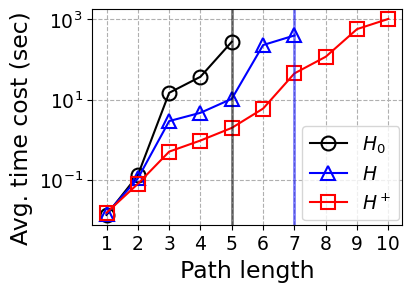

In [92]:

# y is log scale
# let the marker be hollow

metric = 'time_cost'

plt.figure(figsize=figsize)

cut_end_dict = {}

for method in methods:
    
    # cut if more than 25% of the data is timeout
    cut_end = None
    for i, path_length in enumerate(path_lengths):
        records = grouped_data[method][path_length]['records']
        if len(records) == 0:
            continue
        total_cnt = len(records)
        timeout_cnt = len([record for record in records if 'TIMEOUT' in record[7]])
        # print(f'{method} {path_length}: {timeout_cnt}/{total_cnt}={timeout_cnt / total_cnt:.2f}')
        if timeout_cnt / total_cnt > 0.25:
            cut_end = i
            break
    cut_end_dict[method] = cut_end
    
    tmp_path_lengths = list(path_lengths)
    tmp_mean_data = [grouped_data[method][path_length][metric]['mean'] for path_length in path_lengths]
    
    if cut_end is not None:
        tmp_path_lengths = tmp_path_lengths[:cut_end]
        tmp_mean_data = tmp_mean_data[:cut_end]
    
    plt.plot(
        tmp_path_lengths,
        tmp_mean_data,
        label=METHOD_STR_TO_NAME[method],
        color=color_dict[method],
        marker=symbol_dict[method],
        markerfacecolor='none',
        markeredgewidth=1.5,
        markersize=10,
    )


plt.yscale('log')
plt.xlabel('Path length', fontsize=fs, y=0.5)
plt.ylabel(metric_name_dict[metric], fontsize=fs, y=0.45)
plt.xticks(list(range(min(path_lengths), max(path_lengths) + 1)))
plt.tick_params(axis='x', labelsize=sfs)
plt.tick_params(axis='y', labelsize=sfs)
plt.grid(linestyle='--')

# move the legend to the upper left
# plt.legend(loc='lower right', fontsize=sfs)
plt.legend(bbox_to_anchor=(1.02, 0.5), fontsize=sfs)

# plt.axhline(y=timeout, color='gray', linestyle='--', label='Timeout')
# plt.text(min(path_lengths), timeout, 'Timeout', fontsize=fs, va='center',
#          bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

# plt.axhline(y=1, color='gray', linestyle='--', label='1 sec')
# plt.text(5.5, 1, '1 sec', fontsize=fs, va='center',
#          bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

# cut of line
for method, cut_end in cut_end_dict.items():
    if cut_end is not None:
        plt.axvline(x=cut_end, color=color_dict[method], linestyle='-', alpha=0.5, linewidth=2)


plt.savefig(os.path.join(FIGURE_PATH, 'time_cost.pdf'), bbox_inches='tight', pad_inches=0.01)
plt.show()

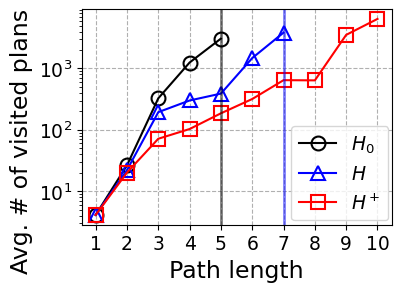

In [93]:
metric = 'generated_plan_cnt'

plt.figure(figsize=figsize)

for method in methods:
    cut_end = cut_end_dict[method]

    tmp_path_lengths = list(path_lengths)
    tmp_mean_data = [grouped_data[method][path_length][metric]['mean'] for path_length in path_lengths]
    
    if cut_end is not None:
        tmp_path_lengths = tmp_path_lengths[:cut_end]
        tmp_mean_data = tmp_mean_data[:cut_end]
    
    plt.plot(
        tmp_path_lengths,
        tmp_mean_data,
        label=METHOD_STR_TO_NAME[method],
        color=color_dict[method],
        marker=symbol_dict[method],
        markerfacecolor='none',
        markeredgewidth=1.5,
        markersize=10,
    ) 
    

plt.yscale('log')
plt.xlabel('Path length', fontsize=fs)
plt.ylabel(metric_name_dict[metric], fontsize=fs, y=0.39)
# set x ticks text
plt.xticks(list(range(min(path_lengths), max(path_lengths) + 1)))
plt.tick_params(axis='x', labelsize=sfs)
plt.tick_params(axis='y', labelsize=sfs)
plt.grid(linestyle='--')
# plt.legend(fontsize=sfs, loc='lower right')
plt.legend(bbox_to_anchor=(1.02, 0.5), fontsize=sfs)
# cut of line
for method, cut_end in cut_end_dict.items():
    if cut_end is not None:
        plt.axvline(x=cut_end, color=color_dict[method], linestyle='-', alpha=0.5, linewidth=2)

plt.savefig(os.path.join(FIGURE_PATH, 'explored_plan_cnt.pdf'), bbox_inches='tight', pad_inches=0.01)
plt.show()

<>:45: SyntaxWarning: invalid escape sequence '\ '
<>:45: SyntaxWarning: invalid escape sequence '\ '
/var/folders/bb/61yl9pgs6pxf41cplw3p8d4r0000gn/T/ipykernel_24723/1381173189.py:45: SyntaxWarning: invalid escape sequence '\ '
  ax.set_xlabel('$e^{(path\ length)} \cdot (plan\ node\ \#)$', fontsize=fs)


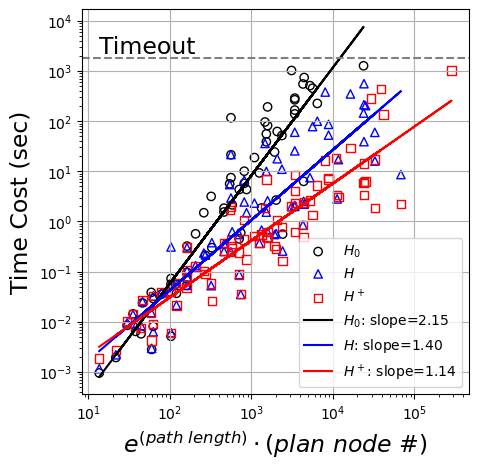

In [94]:
def get_difficulty_factor(path_length, plan_node_cnt):
    # path length is exponentially dependent on the difficulty factor
    # plan node # is linearly dependent on the difficulty factor
    return math.e ** path_length * plan_node_cnt

# a scatter plot: difficulty factor vs time cost
# different methods in different colors and shapes
# set opacity for each point
# set color: black, blue, red
# set symbol: circle, triangle, square (not solid, but hollow)

fig, ax = plt.subplots(figsize=(5, 5))

plot_data = []
timeout_plot_data = []
for method in methods:
    # x: difficulty factor, y: time cost
    # only remian SUCCESS cases
    x, y, colors = [], [], []
    to_x, to_y, to_colors = [], [], []
    for row in data:
        if row[3] == method:
            if 'SUCCESS' not in row[7]:
                to_x.append(get_difficulty_factor(row[6], row[4]))
                to_y.append(row[8])
                to_colors.append(color_dict[method])
            else:
                x.append(get_difficulty_factor(row[6], row[4]))
                y.append(row[8])
                colors.append(color_dict[method])

    plot_data.append((method, x, y, colors))
    timeout_plot_data.append((method, to_x, to_y, to_colors))

for method, x, y, colors in plot_data:
    ax.scatter(x, y, edgecolors=colors, facecolors='none', label=METHOD_STR_TO_NAME[method], marker=symbol_dict[method])

# for method, x, y, colors in timeout_plot_data:
#     # scatter without lengen
#     ax.scatter(x, y, edgecolors=colors, facecolors='none', marker=symbol_dict[method])

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('$e^{(path\ length)} \cdot (plan\ node\ \#)$', fontsize=fs)
ax.set_ylabel('Time Cost (sec)', fontsize=fs)
ax.grid()
ax.legend()

# draw a line for each method

for method, x, y, colors in plot_data:
    x = np.array(x)
    y = np.array(y)
    slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(x), np.log(y))
    ax.plot(x, np.exp(intercept) * x ** slope, color=color_dict[method], label=f'{METHOD_STR_TO_NAME[method]}: slope={slope:.2f}')


# a dashed line for timeout
ax.axhline(y=timeout, color='gray', linestyle='--')
# text for timeout
ax.text(min(x), timeout, 'Timeout', fontsize=fs, va='bottom')

# no legend for timeout
ax.legend()

plt.show()